# Evalauting Popular Assets

Rohan Chhatre & Guillermo Mascaro Madera

## Introduction

What should I invest in? This is a question that has baffled investors for years. With so many assets readily available for purchase in our modern economy, it is becoming increasingly difficult to establish a personal portfolio.

The following tutorial will analyze 5 popular assets:

- American Farm Land
- Bitcoin
- The S&P 500 ($SPX)
- Gold
- Crude Oil

For some context, bitcoin is the most popular cryptocurrency with the largest market cap. The S&P 500 is an index fund which is essentially as single stock that represents the top 500 companies in the United States. Crude oil is a non-renewable energy source used mainly for energy and is the what you fill into your car at the gas station. Gold and American farm land are exactly what the names suggest. 

We seek to determine which of these asset has the best historical performance and which asset is predicted to yield the most returns in the future. Furthermore, we will inspect how well a linear regression model performs with each of the assets and their associated risk. 


Below are all the python libraries that will be utilized in this tutorial.

In [58]:
# standard Python libraries for data science
import numpy as np
import pandas as pd
import sklearn
from sklearn import linear_model

# Python libraries for HTTP requests of data from web pages
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup

# standard default dictionary module
from collections import defaultdict

# Python libraries for graphing and visualizations
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from scipy.stats import pearsonr #for hypothesis testing

## Part 1: Data Curation, Parsing, and Management

American farm land data, more specifically average farm real estate value, was the least appealing to collect (as a data scientist). The most accurate data was published by the US Department of Agriculture but only in the form of a chart, not an easily scrabable table. Thus the data for American farm land is hardcoded below, a method that is difficult to scale but necessary for this project. 

The original farm land data can be found here: https://www.nass.usda.gov/Charts_and_Maps/Land_Values/index.php

In [59]:
land_data = {
    'Year': [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'Dollars_Per_Acre': [2090, 2150, 2300, 2520, 2730, 2940, 3000, 2990, 3030, 3100, 3140, 3130, 3330, 3720, 3970]
}

land_df = pd.DataFrame(land_data)

# Display the DataFrame
print(land_df)

    Year  Dollars_Per_Acre
0   2009              2090
1   2010              2150
2   2011              2300
3   2012              2520
4   2013              2730
5   2014              2940
6   2015              3000
7   2016              2990
8   2017              3030
9   2018              3100
10  2019              3140
11  2020              3130
12  2021              3330
13  2022              3720
14  2023              3970


There was a plethora of data available for historical bitcoin prices, which is intuitive given the nature of public blockchain technology. We downloaded a csv table (which is included in the git repository) which contains data conerning the price of bitcoin from the first day of every month begining in the August of 2010 all the way to the May of 2024. 

The original bitcoin data can be found here: https://www.investing.com/crypto/bitcoin/historical-data 

In [60]:
# Path to CSV file
file_path = './data/bitcoindata.csv'

# Read the CSV file
bitcoin_df = pd.read_csv(
    file_path, 
    thousands=',',  # This tells pandas to treat commas as thousands separators
    parse_dates=['Date'],  # Parses the 'Date' column as datetime objects
    converters={'Change %': lambda x: float(x.strip('%')) / 100}  # Convert the 'Change %' from string to float and remove the '%' sign
)

# Display
print(bitcoin_df.head())

        Date    Price     Open     High      Low     Vol.  Change %
0 2024-05-01  61361.9  60665.0  65448.8  56643.5  853.38K    0.0115
1 2024-04-01  60666.6  71329.3  72710.8  59228.7    2.66M   -0.1495
2 2024-03-01  71332.0  61157.3  73740.9  60138.2    2.70M    0.1661
3 2024-02-01  61169.3  42580.1  63915.3  41890.5    1.74M    0.4366
4 2024-01-01  42580.5  42272.5  48923.7  38546.9    2.03M    0.0073


Data concerning the S&P 500, gold, and crude oil were all readily available online in the form of a table. By employing the BeautifulSoap and requests library, these online tables could easily be transformed into easy to manipulate panda tables. 

The original S&P 500 data can be found here: https://www.macrotrends.net/2324/sp-500-historical-chart-data 

The original gold data can be found here: https://www.macrotrends.net/1333/historical-gold-prices-100-year-chart 

The original crude oil data can be found here: https://www.macrotrends.net/1369/crude-oil-price-history-chart 

In [61]:
def get_df(url):
    # Start the browser, get data
    driver = webdriver.Chrome()    
    driver.get(url)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')

    # Find the correct table element and sections within
    table = soup.find('table', class_='table')
    headers = table.find_all('thead')[1].find_all('th')  # Adjust to select the correct header
    rows = table.find('tbody').find_all('tr')
    
    header_names = [header.text.strip().replace('\n', ' ').replace('  ', ' ') for header in headers]

    data = []
    for row in rows:
        cols = row.find_all('td')
        data.append([col.text.strip() for col in cols])

    # Create a DataFrame
    if len(data) > 0:  # Check if there is data
        df = pd.DataFrame(data, columns=header_names)
        print(df.head(2))
        print(df.tail(2))
        driver.quit()
        df.columns = ['Year', 'Average_Closing_Price', 'Year_Open', 'Year_High', 'Year_Low', 'Year_Close', 'Annual_Change_Percent']
        return df
    else:
        print("No data found.")
        driver.quit()
        return None


# URLs to scrape
etf_df = get_df('https://www.macrotrends.net/2324/sp-500-historical-chart-data')
gold_df = get_df('https://www.macrotrends.net/1333/historical-gold-prices-100-year-chart')
oil_df = get_df('https://www.macrotrends.net/1369/crude-oil-price-history-chart')



   Year AverageClosing Price Year Open Year High  Year Low Year Close  \
0  2024             5,047.91  4,742.83  5,308.15  4,688.68   5,303.27   
1  2023             4,283.73  3,824.14  4,783.35  3,808.10   4,769.83   

  Annual% Change  
0         11.18%  
1         24.23%  
    Year AverageClosing Price Year Open Year High Year Low Year Close  \
95  1929                26.19     24.81     31.86    17.66      21.45   
96  1928                19.94     17.76     24.35    16.95      24.35   

   Annual% Change  
95        -11.91%  
96         37.88%  
   Year AverageClosing Price  Year Open  Year High   Year Low Year Close  \
0  2024            $2,166.70  $2,064.61  $2,414.33  $1,992.06  $2,414.33   
1  2023            $1,943.00  $1,824.16  $2,115.10  $1,811.27  $2,062.92   

  Annual% Change  
0         17.03%  
1         13.08%  
    Year AverageClosing Price Year Open Year High Year Low Year Close  \
54  1970               $35.96    $35.13    $39.19   $34.78     $37.38   
55  1969   

We have now obtained data frames containing metrics surround all 5 of our assets.

One of the most insightful analyses we can conducts is comparing the performance of all these assets over the same time period. In order to accomplish this we will need to manipulate some of the dataframes. 

Farmland, S&P500, gold, and crude oil data are all simple as their dataframed already contain an average value for every year. We just need to make sure that we graph data from 2000 and onwards so that our future plots do not contain too much information. The bitcoin data will need to be tweaked as it contains data for every month, when we want data for every year.

In [62]:
# Convert to datetime and extract
gold_df['Year'] = pd.to_datetime(gold_df['Year']).dt.year
etf_df['Year'] = pd.to_datetime(etf_df['Year']).dt.year
oil_df['Year'] = pd.to_datetime(oil_df['Year']).dt.year

def our_to_numeric(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            try:
                df[column] = df[column].str.replace(',', '')
                df[column] = df[column].str.replace('$', '')
                df[column] = pd.to_numeric(df[column])
            except ValueError:
                # if conversion to numeric is not possible
                pass
    return df
# convert columns to floats
gold_df = our_to_numeric(gold_df)
etf_df = our_to_numeric(etf_df)
oil_df = our_to_numeric(oil_df)
bitcoin_df = our_to_numeric(bitcoin_df)
land_df = our_to_numeric(land_df)

# Filter for years 2010 and later
gold_df_new = gold_df[gold_df['Year'] >= 2010]
etf_df_new = etf_df[etf_df['Year'] >= 2010]
oil_df_new = oil_df[oil_df['Year'] >= 2010]

# Ensure datetime format
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])

# Extract year from 'Date'
bitcoin_df['Year'] = bitcoin_df['Date'].dt.year

def convert_vol_to_numeric(vol_str):
    if not isinstance(vol_str, float):
        if vol_str.endswith('K'):
            return float(vol_str[:-1]) * 1000  
        elif vol_str.endswith('M'):
            return float(vol_str[:-1]) * 1000000
        elif vol_str.endswith('B'):
            return float(vol_str[:-1]) * 1000000000  
    else:
        return float(vol_str)
# Apply the function to the 'Vol.' column to convert it to numeric
bitcoin_df['Vol.'] = bitcoin_df['Vol.'].apply(convert_vol_to_numeric)

# Group by 'Year' and calculate average price
bitcoin_df_averaged_by_year = bitcoin_df.groupby('Year').agg({
    'Price': 'mean',
    'Open': 'mean',
    'High': 'mean',
    'Low': 'mean',
    'Vol.': 'mean', 
    'Change %': 'mean'
}).reset_index()

# Rename columns
bitcoin_df_averaged_by_year.columns = ['Year', 'Average_Price',"Year_Open","Year_High","Year_Low","Volume (USD)",'Annual_Change_Percent']

# Display
bitcoin_df_averaged_by_year


,Year,Average_Price,Year_Open,Year_High,Year_Low,Volume (USD),Annual_Change_Percent
0,2010,0.180000,0.140000,0.260000,0.080000,5.276900e+05,0.510160
1,2011,5.683333,5.316667,8.441667,3.366667,1.127178e+06,0.525417
2,2012,8.450000,7.716667,9.475000,6.958333,1.685908e+06,0.099242
3,2013,260.350000,194.316667,317.691667,111.925000,1.500882e+06,0.700100
4,2014,513.041667,553.683333,637.066667,397.241667,3.676667e+05,-0.053867
5,2015,276.225000,266.908333,317.375000,233.583333,2.298333e+06,0.040183
6,2016,589.800000,545.350000,636.241667,511.283333,1.633684e+06,0.078117
7,2017,4299.758333,3225.691667,5104.041667,2780.908333,3.119167e+06,0.276183
8,2018,7183.125000,8028.141667,9165.716667,6025.566667,2.872500e+07,-0.084200
9,2019,7325.841667,7035.566667,8753.166667,6150.833333,2.987750e+07,0.075950


## Part 2: Exploratory Data Analysis 

Now that we have curated our data into an easily comparable form, lets see which asset makes the best impression on a chart. 

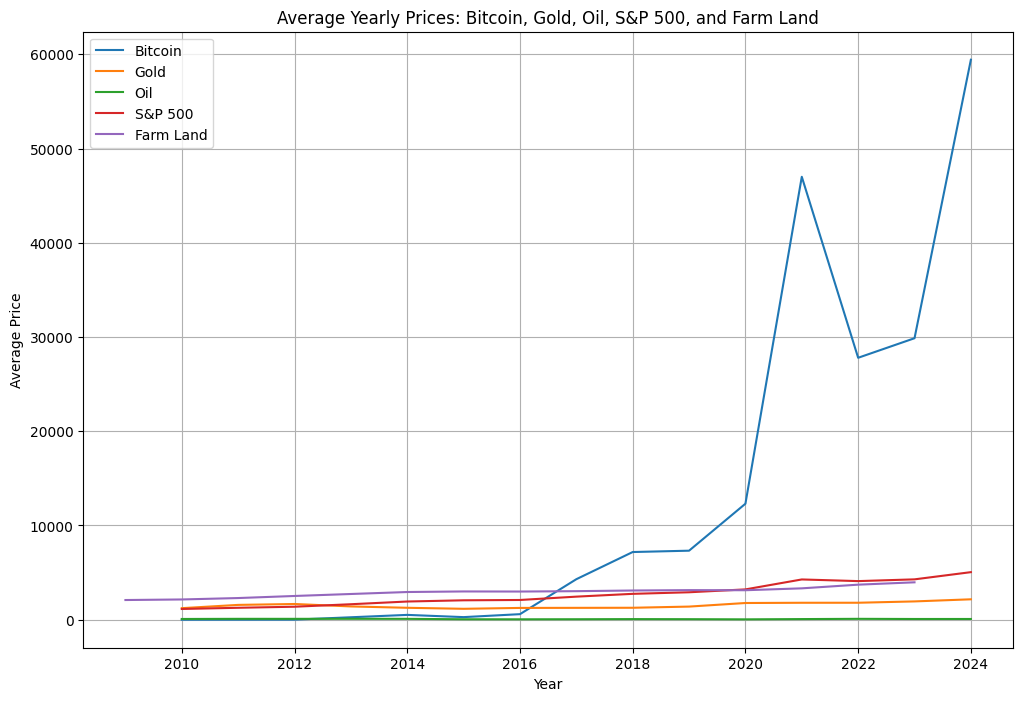

In [63]:
plt.figure(figsize=(12, 8))

# Plot each DataFrame using line plots
plt.plot(bitcoin_df_averaged_by_year['Year'], bitcoin_df_averaged_by_year['Average_Price'], label='Bitcoin')
plt.plot(gold_df_new['Year'], gold_df_new['Average_Closing_Price'], label='Gold')
plt.plot(oil_df_new['Year'], oil_df_new['Average_Closing_Price'], label='Oil')
plt.plot(etf_df_new['Year'], etf_df_new['Average_Closing_Price'], label='S&P 500')
plt.plot(land_df['Year'], land_df['Dollars_Per_Acre'], label='Farm Land')

# title and labels
plt.title('Average Yearly Prices: Bitcoin, Gold, Oil, S&P 500, and Farm Land')
plt.xlabel('Year')
plt.ylabel('Average Price')

plt.legend() 
plt.grid(True) 

plt.show()



/var/folders/dq/frg9njsx0yn5_0sby47kr6dm0000gn/T/ipykernel_42902/2240460574.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_df_new['Annual_Change'] = gold_df_new['Average_Closing_Price'].pct_change() * 100
/var/folders/dq/frg9njsx0yn5_0sby47kr6dm0000gn/T/ipykernel_42902/2240460574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_df_new['Annual_Change'] = oil_df_new['Average_Closing_Price'].pct_change() * 100
/var/folders/dq/frg9njsx0yn5_0sby47kr6dm0000gn/T/ipykernel_42902/2240460574.py:5: Se

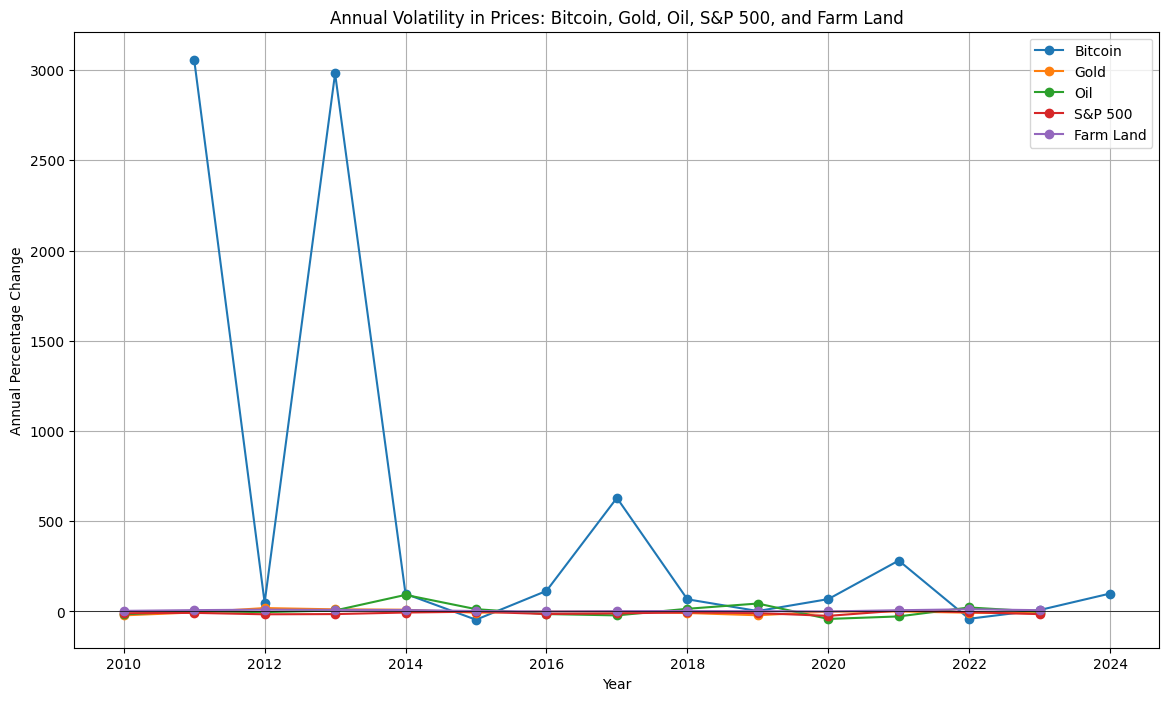

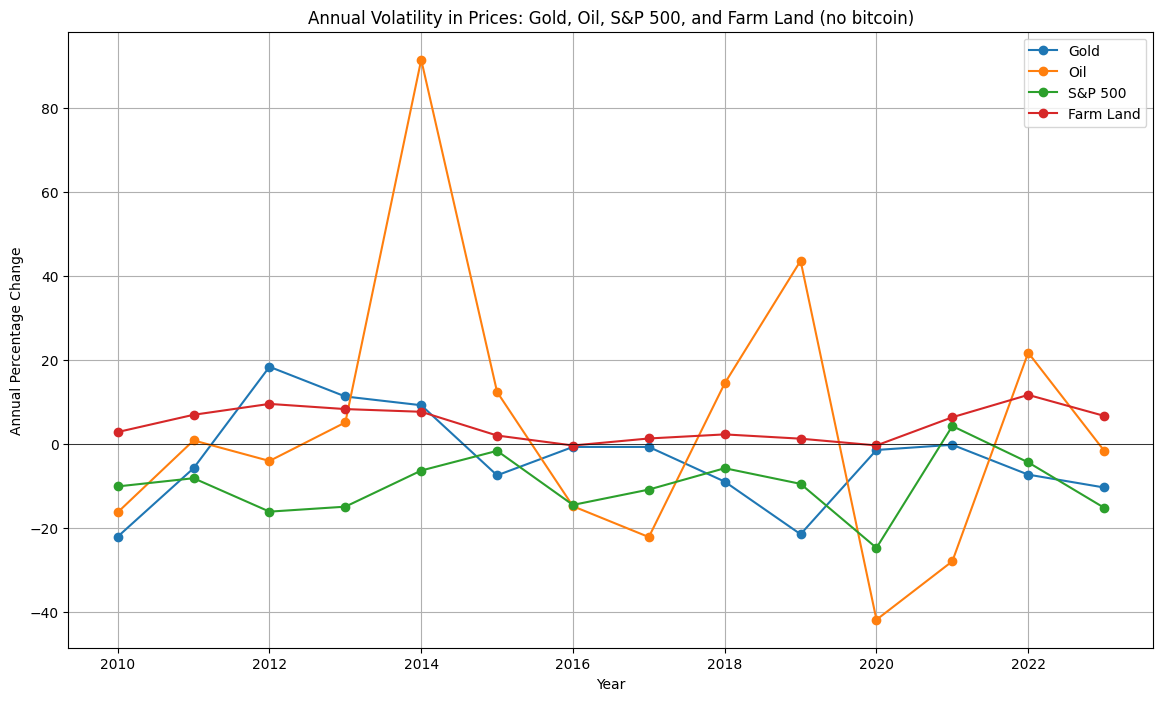

In [70]:
# Calculate annual percentage changes
bitcoin_df_averaged_by_year['Annual_Change'] = bitcoin_df_averaged_by_year['Average_Price'].pct_change() * 100
gold_df_new['Annual_Change'] = gold_df_new['Average_Closing_Price'].pct_change() * 100
oil_df_new['Annual_Change'] = oil_df_new['Average_Closing_Price'].pct_change() * 100
etf_df_new['Annual_Change'] = etf_df_new['Average_Closing_Price'].pct_change() * 100
land_df['Annual_Change'] = land_df['Dollars_Per_Acre'].pct_change() * 100

# Plotting all annual percentage changes
plt.figure(figsize=(14, 8)) 

plt.plot(bitcoin_df_averaged_by_year['Year'], bitcoin_df_averaged_by_year['Annual_Change'], label='Bitcoin', marker='o')
plt.plot(gold_df_new['Year'], gold_df_new['Annual_Change'], label='Gold', marker='o')
plt.plot(oil_df_new['Year'], oil_df_new['Annual_Change'], label='Oil', marker='o')
plt.plot(etf_df_new['Year'], etf_df_new['Annual_Change'], label='S&P 500', marker='o')
plt.plot(land_df['Year'], land_df['Annual_Change'], label='Farm Land', marker='o')

plt.title('Annual Volatility in Prices: Bitcoin, Gold, Oil, S&P 500, and Farm Land')
plt.xlabel('Year')
plt.ylabel('Annual Percentage Change')
plt.legend()
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)  # Add a horizontal line at 0% change for reference
plt.show()

# Plotting all annual percentage changes except bitcoin 
plt.figure(figsize=(14, 8)) 

#plt.plot(bitcoin_df_averaged_by_year['Year'], bitcoin_df_averaged_by_year['Annual_Change'], label='Bitcoin', marker='o')
plt.plot(gold_df_new['Year'], gold_df_new['Annual_Change'], label='Gold', marker='o')
plt.plot(oil_df_new['Year'], oil_df_new['Annual_Change'], label='Oil', marker='o')
plt.plot(etf_df_new['Year'], etf_df_new['Annual_Change'], label='S&P 500', marker='o')
plt.plot(land_df['Year'], land_df['Annual_Change'], label='Farm Land', marker='o')

plt.title('Annual Volatility in Prices: Gold, Oil, S&P 500, and Farm Land (no bitcoin)')
plt.xlabel('Year')
plt.ylabel('Annual Percentage Change')
plt.legend()
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)  # Add a horizontal line at 0% change for reference
plt.show()

Selecting an asset to invest in involves analyzing both gain potential and volatility. If we ignored volatility and simply observed gains in the last decade then putting our entire portfolio into bitcoin would seem like a no brainer. However, bitcoin is also by far the most volatile asset in this study. We even include a seperate volatility plot because of how much bitcoin volatility skews our comparison. 

The results show that oil is not a very good investment given that it is very volatile but also shows very little promise of long-term growth. Bitcoin is a high risk, high reward investment which shows excellent long term growth. Farm land and gold are both very safe investments that show modest long term growth. The S&P500 is slightly more volatile than land and gold but also more promising for long-term growth.

At this point, we have an idea of the risk and benefits associated with each asset. However, we want to see if the data forms any predicatbale patterns that will allow us to formulate a strategy that is exploits historical data as much as possible to create a profitable long-term investment plan. 

## Part 3: Hypothesis Testing and Machine Learning To Provide Analysis

## Hypothesis Testing



In [69]:

# Compute the correlation matrix for all assets
columns_to_extract_from_bitcoin = bitcoin_df_averaged_by_year[["Year",'Average_Price',"Year_Open","Year_High","Year_Low","Volume (USD)"]]
columns_to_extract_from_gold = gold_df_new[['Average_Closing_Price',"Year_Open","Year_High","Year_Low","Year_Close"]]
columns_to_extract_from_oil = oil_df_new[['Average_Closing_Price',"Year_Open","Year_High","Year_Low","Year_Close"]]
columns_to_extract_from_etf = etf_df_new[['Average_Closing_Price',"Year_Open","Year_High","Year_Low","Year_Close"]]
columns_to_extract_from_land = land_df[['Dollars_Per_Acre']]
combined_df = pd.concat([columns_to_extract_from_bitcoin,columns_to_extract_from_gold,columns_to_extract_from_oil,columns_to_extract_from_etf,columns_to_extract_from_land], axis=1)
combined_df.columns = ["Year",'Bitcoin_Average_Closing_Price', "Bitcoin_Year_Open","Bitcoin_Year_High","Bitcoin_Year_Low","Bitcoin_Volume (USD)",'Gold_Average_Closing_Price', "Gold_Year_Open", "Gold_Year_High","Gold_Year_Low","Gold_Year_Close",'Oil_Average_Closing_Price', "Oil_Year_Open", "Oil_Year_High","Oil_Year_Low","Oil_Year_Close",'S&P500_Average_Closing_Price',"S&P500_Year_Open", "S&P500_Year_High","S&P500_Year_Low","S&P500_Year_Close", 'Farm_Land_Dollars_Per_Acre']


all_features = ['Bitcoin_Average_Closing_Price', "Bitcoin_Year_Open","Bitcoin_Year_High","Bitcoin_Year_Low", "Bitcoin_Volume (USD)", 'Gold_Average_Closing_Price', "Gold_Year_Open", "Gold_Year_High","Gold_Year_Low","Gold_Year_Close",'Oil_Average_Closing_Price', "Oil_Year_Open", "Oil_Year_High","Oil_Year_Low","Oil_Year_Close",'S&P500_Average_Closing_Price',"S&P500_Year_Open", "S&P500_Year_High","S&P500_Year_Low","S&P500_Year_Close", 'Farm_Land_Dollars_Per_Acre']

correlation_results = pd.DataFrame(columns=['Asset 1', 'Asset 2', 'Correlation', 'P-value', 'Significance'])

for i in range(len(all_features)):
    for j in range(i+1, len(all_features)):
        asset1 = all_features[i]
        asset2 = all_features[j]
        
        # drop null data
        valid_data = combined_df[[asset1, asset2]].dropna()
        
        # Calculate correlation and p-value only if there is enough data
        if len(valid_data) > 1:
            corr, p_value = pearsonr(valid_data[asset1], valid_data[asset2])
            if p_value < 0.0001:
                significance = 'Statistically significant (reject null hypothesis)'
            else:
                significance = 'Not statistically significant'
            
            # Prepare a temporary DataFrame for appending
            temp_df = pd.DataFrame({
                'Asset 1': [asset1],
                'Asset 2': [asset2],
                'Correlation': [corr],
                'P-value': [p_value],
                'Significance': [significance]
            })
            
            # Append results using concat
            correlation_results = pd.concat([correlation_results, temp_df], ignore_index=True)


# Display
correlation_results


/var/folders/dq/frg9njsx0yn5_0sby47kr6dm0000gn/T/ipykernel_42902/1783118719.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results = pd.concat([correlation_results, temp_df], ignore_index=True)


,Asset 1,Asset 2,Correlation,P-value,Significance
0,Bitcoin_Average_Closing_Price,Bitcoin_Year_Open,0.998012,5.378111e-17,Statistically significant (reject null hypothe...
1,Bitcoin_Average_Closing_Price,Bitcoin_Year_High,0.998424,1.191925e-17,Statistically significant (reject null hypothe...
2,Bitcoin_Average_Closing_Price,Bitcoin_Year_Low,0.999182,1.676887e-19,Statistically significant (reject null hypothe...
3,Bitcoin_Average_Closing_Price,Bitcoin_Volume (USD),0.212298,4.474830e-01,Not statistically significant
4,Bitcoin_Average_Closing_Price,Gold_Average_Closing_Price,-0.334836,2.224978e-01,Not statistically significant
...,...,...,...,...,...
205,S&P500_Year_High,S&P500_Year_Close,0.983223,5.451215e-11,Statistically significant (reject null hypothe...
206,S&P500_Year_High,Farm_Land_Dollars_Per_Acre,-0.942863,1.423853e-07,Statistically significant (reject null hypothe...
207,S&P500_Year_Low,S&P500_Year_Close,0.963207,8.559043e-09,Statistically significant (reject null hypothe...
208,S&P500_Year_Low,Farm_Land_Dollars_Per_Acre,-0.935014,3.224711e-07,Statistically significant (reject null hypothe...


In [ ]:
# Dictionary for correlated features for each asset
correlated_features = {}

# Significance level threshold 
significance_threshold = 0.0001
targets = ['Bitcoin_Average_Closing_Price', 'Gold_Average_Closing_Price', 'Oil_Average_Closing_Price', 'S&P500_Average_Closing_Price', 'Farm_Land_Dollars_Per_Acre']
for asset in targets:
    # Filter
    asset_correlation_results = correlation_results[(correlation_results['Asset 1'] == asset) | (correlation_results['Asset 2'] == asset)]
    significant_correlations = asset_correlation_results[asset_correlation_results['P-value'] < significance_threshold]
    
    # Extract significant correlations
    correlated_features[asset] = significant_correlations.apply(lambda row: row['Asset 1'] if row['Asset 1'] != asset else row['Asset 2'], axis=1).tolist()

# Display correlated features for each asset
for asset, features in correlated_features.items():
    print(f"For asset '{asset}', correlated features are: {features}")

For asset 'Bitcoin_Average_Closing_Price', correlated features are: ['Bitcoin_Year_Open', 'Bitcoin_Year_High', 'Bitcoin_Year_Low']
For asset 'Gold_Average_Closing_Price', correlated features are: ['Gold_Year_Open', 'Gold_Year_High', 'Gold_Year_Low', 'Gold_Year_Close']
For asset 'Oil_Average_Closing_Price', correlated features are: ['Oil_Year_Open', 'Oil_Year_High', 'Oil_Year_Low']
For asset 'S&P500_Average_Closing_Price', correlated features are: ['S&P500_Year_Open', 'S&P500_Year_High', 'S&P500_Year_Low', 'S&P500_Year_Close', 'Farm_Land_Dollars_Per_Acre']
For asset 'Farm_Land_Dollars_Per_Acre', correlated features are: ['S&P500_Average_Closing_Price', 'S&P500_Year_Open', 'S&P500_Year_High', 'S&P500_Year_Low', 'S&P500_Year_Close']


# Preliminary Linear Regression Model
We'll begin by building a basic regression model. It's normal for this initial model to encounter several issues that we'll need to address. The purpose of this phase is to gain a basic understanding of linear regression. We'll refine and finalize our model in subsequent sections.

A linear regression model is used to predict values in a system with a linear correlation between a dependent variable and one or more independent variables. For our initial hypothesis, we predict that the Closing Prices of the 5 assets will depends on the correlated features calculated above. So, for example, we predict that "Bitcoin_Average_Closing_Price" will depend on:

Bitcoin_Average_Closing_Price=β0+β1(Bitcoin_Year_Open)+β2(Bitcoin_Year_High)+β3(Bitcoin_Year_Low)    (using the result from the cell above)


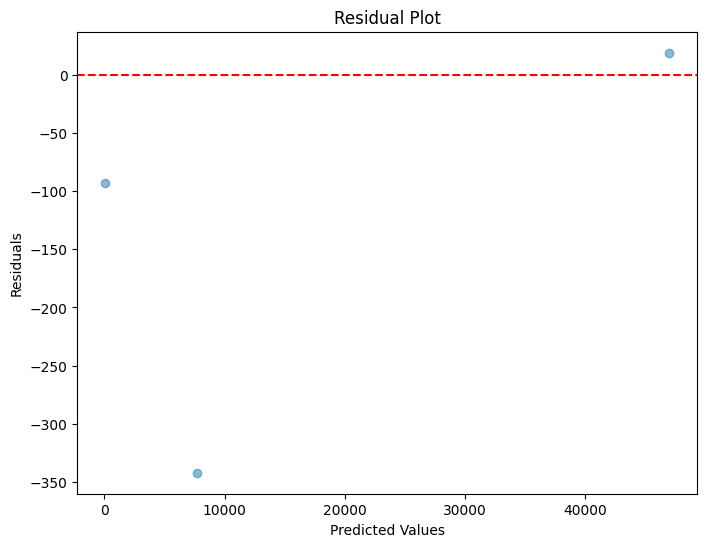

OLS Mean Squared Error for Bitcoin_Average_Closing_Price: 41989.37898140645


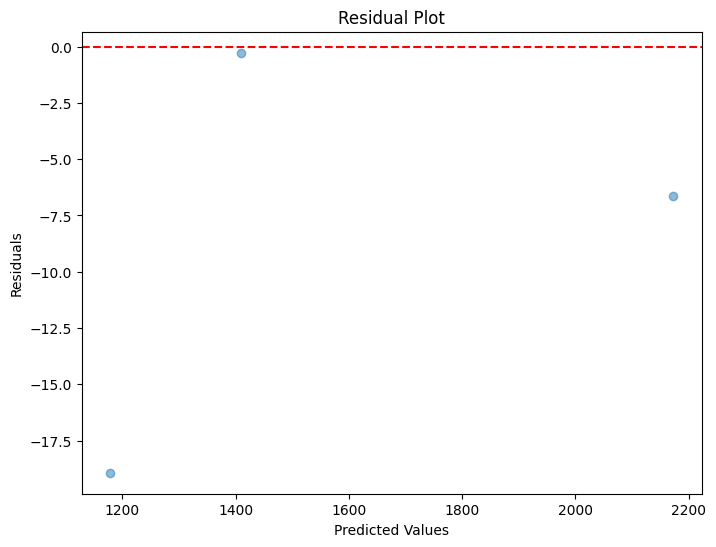

OLS Mean Squared Error for Gold_Average_Closing_Price: 134.08545020273053


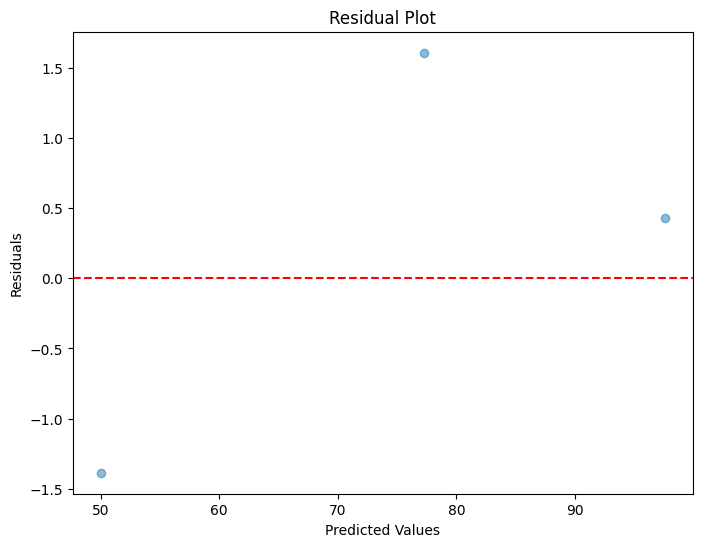

OLS Mean Squared Error for Oil_Average_Closing_Price: 1.5616174301769616


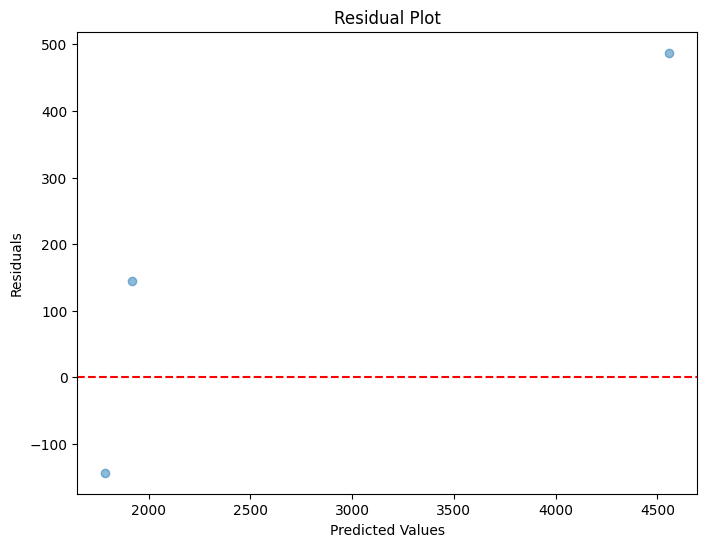

OLS Mean Squared Error for S&P500_Average_Closing_Price: 92999.55371578946


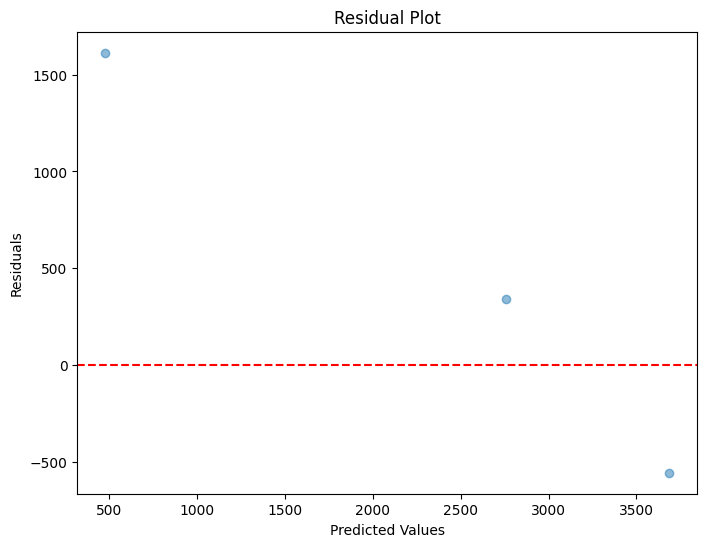

OLS Mean Squared Error for Farm_Land_Dollars_Per_Acre: 1007923.0541300606
Best performing asset: Oil_Average_Closing_Price (MSE: 1.5616174301769616)


In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# List to store MSE for each asset
mse_results = []

targets = ['Bitcoin_Average_Closing_Price', 'Gold_Average_Closing_Price', 'Oil_Average_Closing_Price', 'S&P500_Average_Closing_Price', 'Farm_Land_Dollars_Per_Acre']

# Iterate through each asset
for asset in targets:
    correlated_asset_features = correlated_features[asset]
    
    # Extract features and target variable for the current asset
    X = combined_df[correlated_asset_features]
    X = sm.add_constant(X)  # Add intercept term
    y = combined_df[asset]
    
    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit OLS model
    ols_model = sm.OLS(y_train, X_train)
    ols_results = ols_model.fit()
    #print(ols_results.summary2())
    
    # Make predictions
    ols_predictions = ols_results.predict(X_test)
    
    # Calculate MSE and residuals
    ols_mse = mean_squared_error(y_test, ols_predictions)
    residuals = y_test - ols_predictions

    # Plot residuals against predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(ols_predictions, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()
    print(f"OLS Mean Squared Error for {asset}: {ols_mse}")
    mse_results.append((asset, ols_mse))

# Find the best performing asset based on MSE
best_asset, best_mse = min(mse_results, key=lambda x: x[1])
print(f"Best performing asset: {best_asset} (MSE: {best_mse})")



In [ ]:
correlation_matrix = combined_df[['Bitcoin_Average_Closing_Price', "Bitcoin_Year_Open","Bitcoin_Year_High","Bitcoin_Year_Low", "Bitcoin_Volume (USD)", 'Gold_Average_Closing_Price', "Gold_Year_Open", "Gold_Year_High","Gold_Year_Low","Gold_Year_Close",'Oil_Average_Closing_Price', "Oil_Year_Open", "Oil_Year_High","Oil_Year_Low","Oil_Year_Close",'S&P500_Average_Closing_Price',"S&P500_Year_Open", "S&P500_Year_High","S&P500_Year_Low","S&P500_Year_Close", 'Farm_Land_Dollars_Per_Acre']].corr()

# Print correlation matrix
print("Correlation Matrix:")
correlation_matrix


Correlation Matrix:


,Bitcoin_Average_Closing_Price,Bitcoin_Year_Open,Bitcoin_Year_High,Bitcoin_Year_Low,Bitcoin_Volume (USD),Gold_Average_Closing_Price,Gold_Year_Open,Gold_Year_High,Gold_Year_Low,Gold_Year_Close,...,Oil_Year_Open,Oil_Year_High,Oil_Year_Low,Oil_Year_Close,S&P500_Average_Closing_Price,S&P500_Year_Open,S&P500_Year_High,S&P500_Year_Low,S&P500_Year_Close,Farm_Land_Dollars_Per_Acre
Bitcoin_Average_Closing_Price,1.000000,0.998012,0.998424,0.999182,0.212298,-0.334836,-0.243264,-0.228326,-0.406058,-0.332586,...,0.578425,0.411629,0.517458,0.646560,-0.728167,-0.715181,-0.722015,-0.692015,-0.702325,0.765002
Bitcoin_Year_Open,0.998012,1.000000,0.998828,0.997558,0.265610,-0.322776,-0.230206,-0.220495,-0.392591,-0.327911,...,0.588420,0.416757,0.525216,0.653733,-0.733418,-0.720903,-0.727592,-0.696944,-0.707794,0.759361
Bitcoin_Year_High,0.998424,0.998828,1.000000,0.996260,0.232050,-0.335085,-0.231999,-0.230355,-0.405217,-0.342262,...,0.576578,0.407393,0.521065,0.645332,-0.728024,-0.716554,-0.721879,-0.691419,-0.701361,0.750834
Bitcoin_Year_Low,0.999182,0.997558,0.996260,1.000000,0.226465,-0.326482,-0.245110,-0.221063,-0.397652,-0.319143,...,0.579776,0.412792,0.515868,0.650059,-0.728676,-0.714362,-0.722806,-0.692926,-0.704006,0.772651
Bitcoin_Volume (USD),0.212298,0.265610,0.232050,0.226465,1.000000,0.118313,0.090460,0.055680,0.150527,0.069945,...,0.441430,0.272038,0.299515,0.298911,-0.298355,-0.300103,-0.304356,-0.273256,-0.299900,0.204490
Gold_Average_Closing_Price,-0.334836,-0.322776,-0.335085,-0.326482,0.118313,1.000000,0.912315,0.981671,0.981365,0.964738,...,0.195278,0.326236,0.294758,0.362189,0.753393,0.735717,0.754869,0.740586,0.763203,-0.703618
Gold_Year_Open,-0.243264,-0.230206,-0.231999,-0.245110,0.090460,0.912315,1.000000,0.896081,0.918499,0.819812,...,0.234930,0.442269,0.444410,0.426935,0.732143,0.704075,0.732985,0.738749,0.728047,-0.708914
Gold_Year_High,-0.228326,-0.220495,-0.230355,-0.221063,0.055680,0.981671,0.896081,1.000000,0.931623,0.939583,...,0.249857,0.378728,0.332088,0.438037,0.680440,0.678651,0.687352,0.659046,0.692397,-0.622794
Gold_Year_Low,-0.406058,-0.392591,-0.405217,-0.397652,0.150527,0.981365,0.918499,0.931623,1.000000,0.953057,...,0.156919,0.304054,0.308136,0.309174,0.804959,0.772482,0.799317,0.809579,0.806120,-0.757941
Gold_Year_Close,-0.332586,-0.327911,-0.342262,-0.319143,0.069945,0.964738,0.819812,0.939583,0.953057,1.000000,...,0.127788,0.223162,0.225028,0.315839,0.760939,0.736173,0.758334,0.745743,0.774970,-0.651439


# Diagnosing Problems
We see that we have pretty good R^2 values for all models ranging from 90% to even 100%. Yet, the problem is that we have a very bad MSE (Mean Square Error) when predicting the prices for some assets. For target assets like Gold_Average_Closing_Price or Oil_Average_Closing_Price, the MSE is pretty good, close to 0 but the other 3 target assets can be improved a lot. We think this is because of 2 main problems:

1. Multicollinearity: Multicollinearity occurs when independent variables in a regression model are highly correlated with each other. This can cause issues with the estimation of the regression coefficients and can affect the interpretation and predictive ability of the model. If we look at the correlation matrix above, it is observable that there are pairs of variables that are strongly related and that are used in the linear regression of the same target asset, for example, Bitcoin_Year_Open and Bitcoin_Year_High with a 0.998828 correlation.

2. Multiplicative Relationships: In many real-world scenarios, the relationship between predictors and the target variable is not linear but rather multiplicative.For example, in finance and economics, variables such as stock prices, GDP growth rates, and population growth rates often exhibit multiplicative relationships. In multiplicative relationships, the effect of a predictor variable on the target variable is proportional to the value of the target variable itself.

3. Heteroscedasticity: In the presence of heteroscedasticity, the variance of the residuals is not constant across all levels of the predictor variables. This means that the errors may be larger for certain observations, leading to a higher overall MSE. Heteroscedasticity can inflate the MSE, especially if the model disproportionately underestimates or overestimates the target variable for certain observations with larger residuals. We can observe this is happening at the plots above.

We know that we have few data points but still we think this diagnosis could explain why we have such a good R^2 but really bad MSE for some assets.

# Solution Proposed
Use of square root transformation. 

1. Sqrt transformation can help alleviate multicollinearity when predictor variables have a multiplicative relationship with the target variable. By transforming the predictor variables using the sqrt, it can reduce the correlation between them, especially if the original variables are highly positively skewed or have a wide range of values.

2. By transforming the target variable and possibly the predictor variables using the sqrt function, it can simplify the modeling process and improve the interpretability of the regression coefficients.

3. Sqrt transformation can stabilize the variance of the residuals when the spread of residuals increases with increasing predicted values (as seen in multiplicative relationships).By applying the Sqrt transformation to the target variable, it can mitigate the effect of heteroscedasticity by compressing the scale of the variable, making the variance more consistent across different levels of the predictors.

    const  Bitcoin_Year_Open  Bitcoin_Year_High  Bitcoin_Year_Low
9     1.0        7035.566667        8753.166667       6150.833333
11    1.0       45557.641667       55696.991667      38120.966667
0     1.0           0.140000           0.260000          0.080000


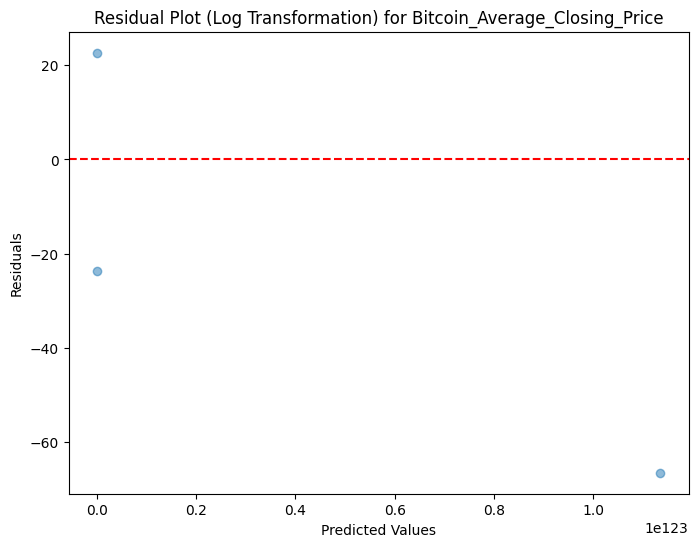

OLS Mean Squared Error for Bitcoin_Average_Closing_Price: 1834.2198070339089
    const  Gold_Year_Open  Gold_Year_High  Gold_Year_Low  Gold_Year_Close
9     1.0         1184.25         1298.00        1049.60          1060.20
11    1.0         1681.50         1692.50        1192.75          1201.50
0     1.0         2064.61         2413.42        1992.06          2413.42


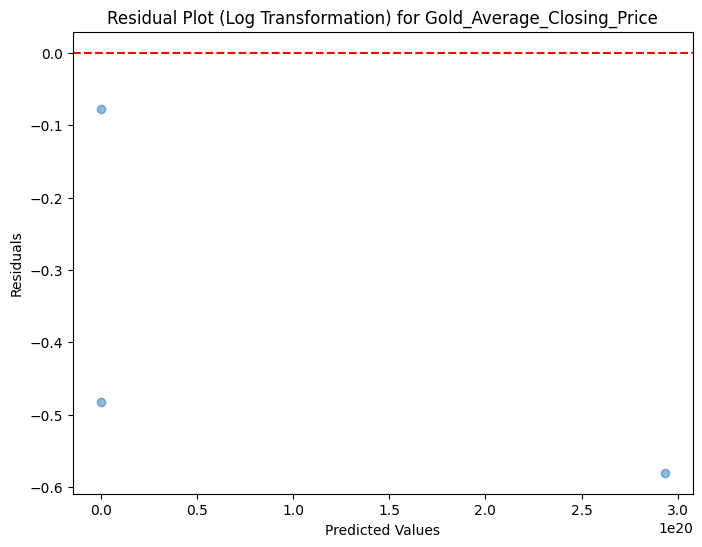

OLS Mean Squared Error for Gold_Average_Closing_Price: 0.1916403488727437
    const  Oil_Year_Open  Oil_Year_High  Oil_Year_Low
9     1.0          52.72          61.36         34.55
11    1.0          93.14         110.62         86.65
0     1.0          71.65          87.01         70.38


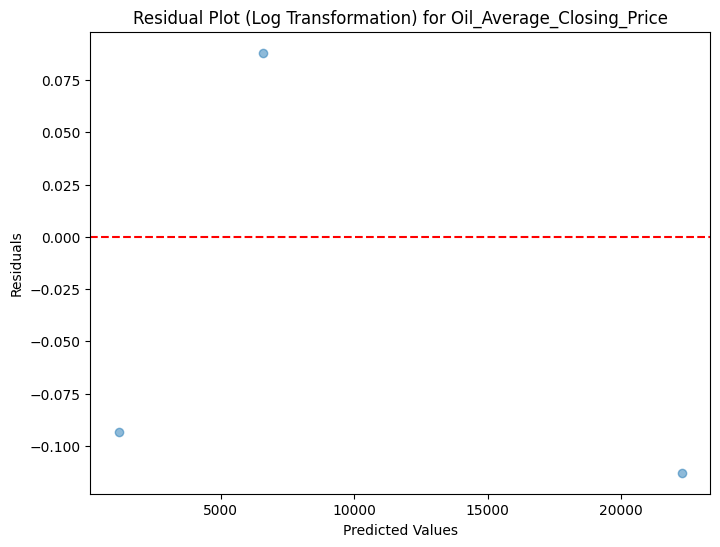

OLS Mean Squared Error for Oil_Average_Closing_Price: 0.009731682194760774
    const  S&P500_Year_Open  S&P500_Year_High  S&P500_Year_Low  \
9     1.0           2058.20           2130.82          1867.61   
11    1.0           1462.42           1848.36          1457.15   
0     1.0           4742.83           5308.15          4688.68   

    S&P500_Year_Close  Farm_Land_Dollars_Per_Acre  
9             2043.94                        3100  
11            1848.36                        3130  
0             5297.10                        2090  


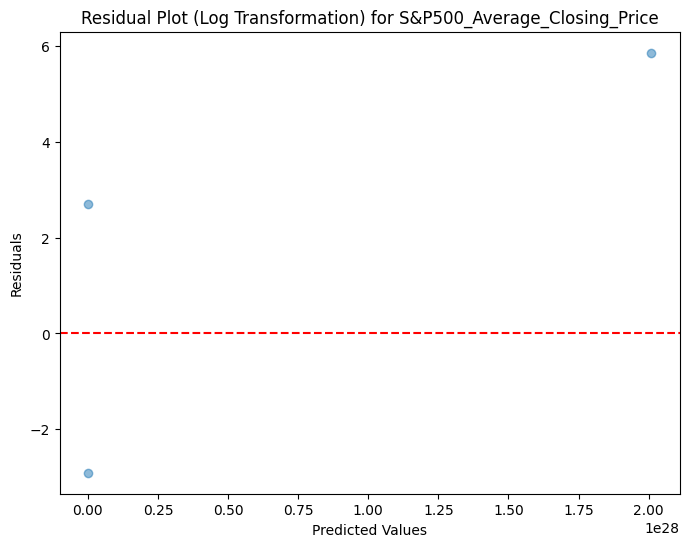

OLS Mean Squared Error for S&P500_Average_Closing_Price: 16.714906525156408
    const  S&P500_Average_Closing_Price  S&P500_Year_Open  S&P500_Year_High  \
9     1.0                       2061.07           2058.20           2130.82   
11    1.0                       1643.80           1462.42           1848.36   
0     1.0                       5045.23           4742.83           5308.15   

    S&P500_Year_Low  S&P500_Year_Close  
9           1867.61            2043.94  
11          1457.15            1848.36  
0           4688.68            5297.10  


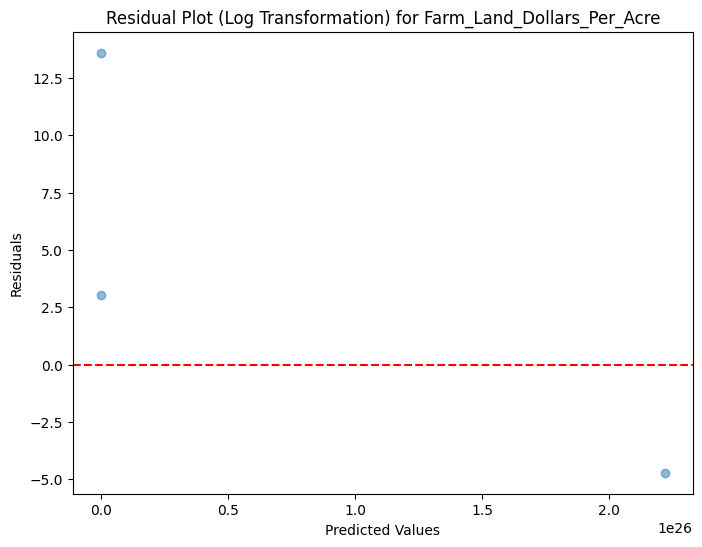

OLS Mean Squared Error for Farm_Land_Dollars_Per_Acre: 72.0551654707955


In [ ]:
# Define the targets
targets = ['Bitcoin_Average_Closing_Price', 'Gold_Average_Closing_Price', 'Oil_Average_Closing_Price', 'S&P500_Average_Closing_Price', 'Farm_Land_Dollars_Per_Acre']

mse_results = []

# Function to train model and make predictions
def train_and_predict(asset):
    # Select correlated features for the current asset
    correlated_asset_features = correlated_features[asset]
    
    # Extract features and target variable for the current asset
    X = combined_df[correlated_asset_features]
    X = sm.add_constant(X)  # Add intercept term
    y = combined_df[asset]
    
    # Apply log transformation to the target variable
    y_sqrt = np.sqrt(y)
    
    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_sqrt, test_size=0.2, random_state=42)
    print(X_test)
    # Fit OLS model
    ols_model = sm.OLS(y_train, X_train)
    ols_results = ols_model.fit()
    
    # Make predictions on the test set
    ols_predictions_log = ols_results.predict(X_test)
    
    # Calculate MSE and residulas
    ols_mse = mean_squared_error(y_test, ols_predictions_log)
    residuals = y_test - ols_predictions_log

    # Plot residuals against predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(np.exp(ols_predictions_log), residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f"Residual Plot (Log Transformation) for {asset}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()
    
    # Print MSE
    print(f"OLS Mean Squared Error for {asset}: {ols_mse}")
    mse_results.append((asset, ols_mse))
    
    return ols_results

# Train and store the models
models = {}
for asset in targets:
    models[asset] = train_and_predict(asset)


# Result
And we see it worked!!!! MSE is reduced by a lot thanks to the log transformation!!!

# Predicting the Price of the Assets for the next few years
Now that our model is predicting with less error, let's try to predict the price of bitcoin for 5 years.
We will now create a future dataset by shifting the original data by . We will use this to make predictions of future prices.

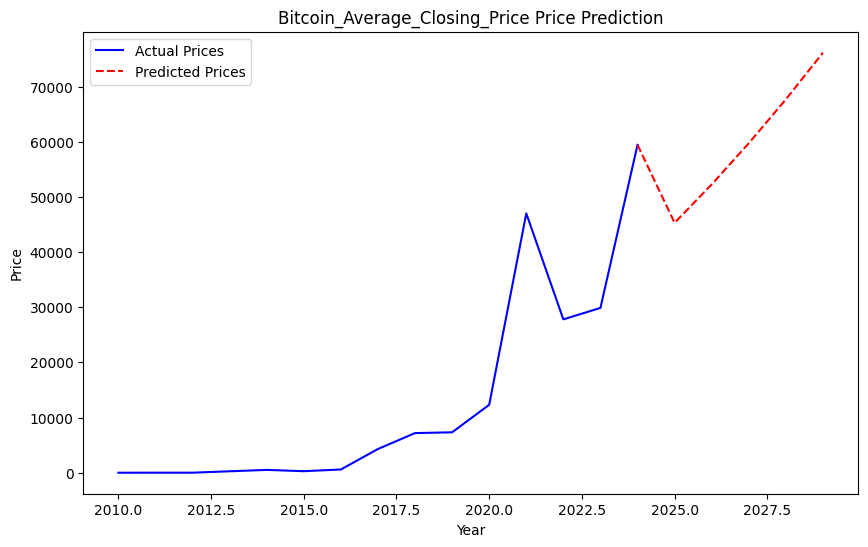

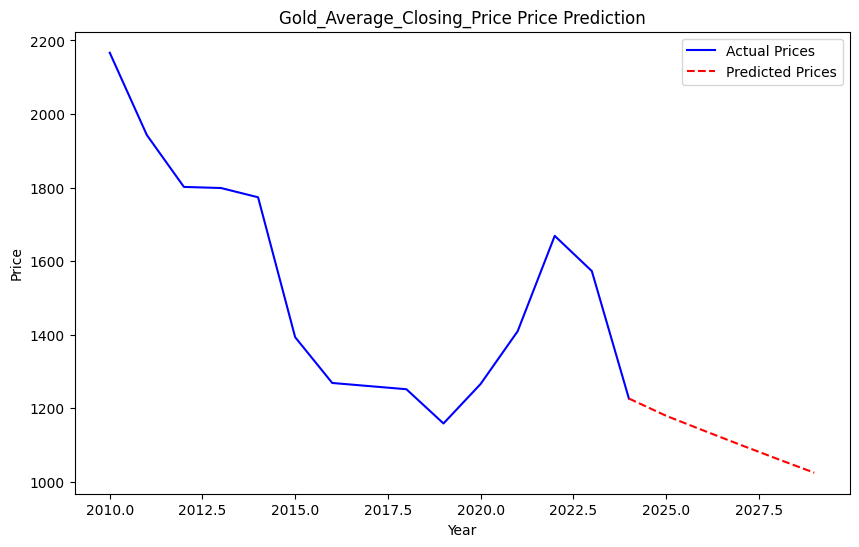

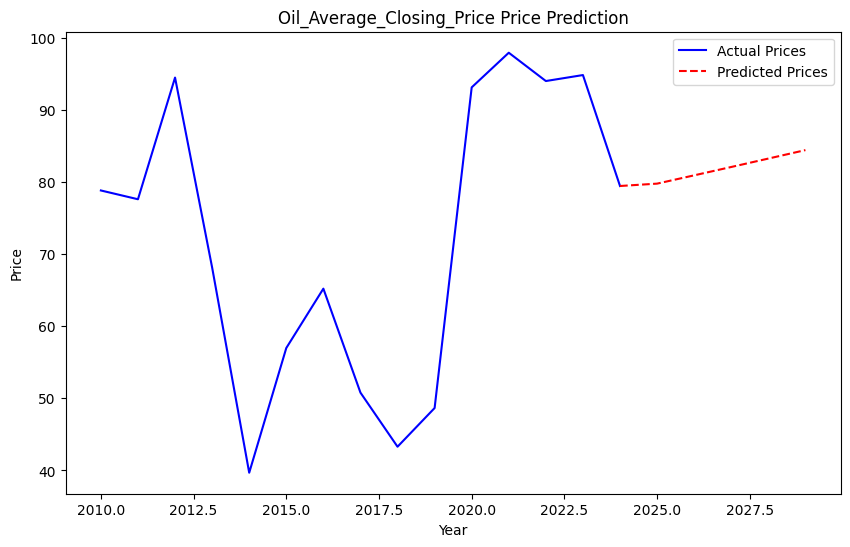

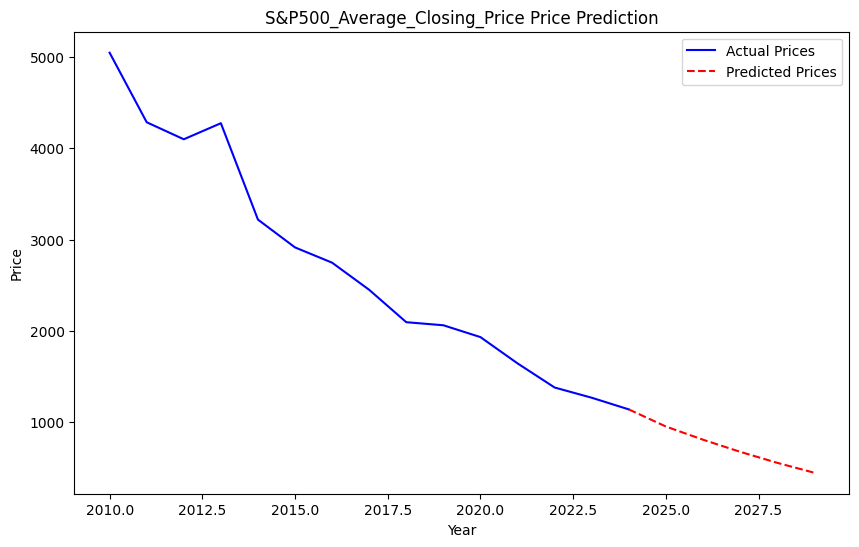

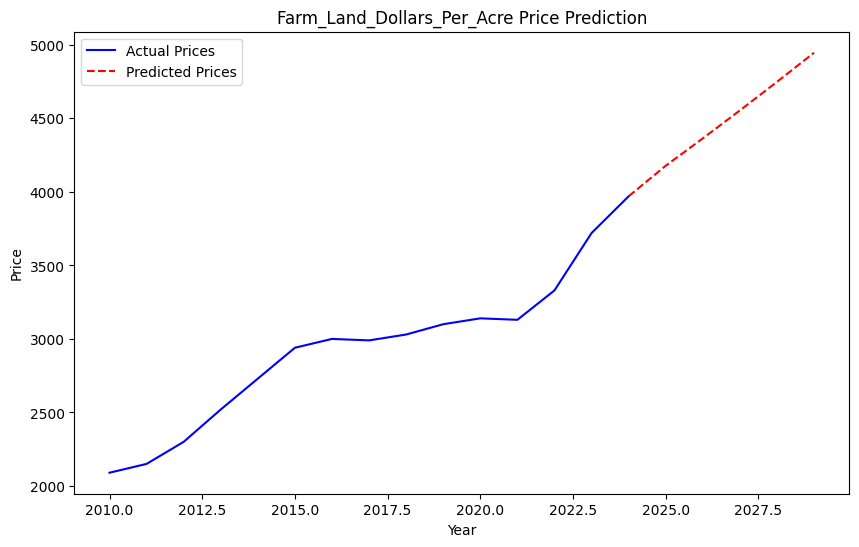

In [ ]:
# Function to forecast future feature values using OLS
def forecast_future_features_ols(correlated_features, years_to_predict):
    future_data = pd.DataFrame()
    future_years = np.arange(combined_df['Year'].max() + 1, combined_df['Year'].max() + 1 + years_to_predict)
    future_data['Year'] = future_years
    
    for feature in correlated_features:
        if feature == 'Year':
            continue
        
        X = combined_df[['Year']]
        y = combined_df[feature]
        
        X = sm.add_constant(X)  
        ols_feature_model = sm.OLS(y, X).fit()
        
        future_X = sm.add_constant(future_years)
        future_values = ols_feature_model.predict(future_X)
        
        future_data[feature] = future_values
    
    return future_data

# Forecast future features and make predictions for each asset
years_to_predict = 5
future_predictions = {}

for asset in targets:
    # Select correlated features for the current asset
    correlated_asset_features = correlated_features[asset]
    
    # Forecast future features
    future_features = forecast_future_features_ols(correlated_asset_features, years_to_predict)
    future_features_without_year = future_features.drop(columns=['Year'])
    
    # Add constant term
    future_features_without_year = sm.add_constant(future_features_without_year)
    
    # Make future predictions using the trained OLS model
    future_predictions_log = models[asset].predict(future_features_without_year)

    future_predictions[asset] = future_predictions_log ** 2
    # Combine actual data's last year with future predictions
    last_actual_year = combined_df[combined_df['Year'] == combined_df['Year'].max()]
    future_data_combined = pd.concat([last_actual_year, future_features])
    future_data_combined[asset] = np.concatenate((last_actual_year[asset], future_predictions[asset]))

    # Plot actual prices and future predictions
    plt.figure(figsize=(10, 6))
    plt.plot(combined_df['Year'], combined_df[asset], label='Actual Prices', color='blue')
    plt.plot(future_data_combined['Year'], future_data_combined[asset], label='Predicted Prices', linestyle='--', color='red')
    plt.title(f"{asset} Price Prediction")
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Mini Analysis

The code above forecasts future values of correlated features for a given number of years using Ordinary Least Squares (OLS) regression. It creates a DataFrame with future years, fits an OLS model to each correlated feature using the existing 'Year' data, predicts future values for these features, and stores them in the DataFrame. The main loop iterates over target assets, forecasts future values of their correlated features, adds a constant term, and predicts future asset prices using pre-trained OLS models. The predicted prices are then squared to reverse the square root transformation applied during training. Finally, it combines the actual last year data with the predicted future data and plots both actual and predicted prices for each asset, ensuring continuity between historical and future data. We can observe the predictions of each asset by observing the plots. We think those predictions are reasonable, they follow the pattern of previous years. Yet, it is important to highlight that in general, this will not work well in the real world. This is because history might not repeat itself. Though, some assets like Bitcoin tend to have repeating cycles.


## Part 4: Message Curation

From part 2, we understood that bitcoin was the asset with the highest risk and highest return. We also observed that the S&P 500 was an asset that showed long-term promise at the expense of some risk. We determined that gold and farm land are both safe investments that will yield solid return in the long term, though potentially not as good as bitcoin and the S&P 500. We also concluded that oil may not be the strongest investment given its minimal growth as well as noticable risk.

Part 3 showed us that gold and oil have the most reliable predictions, given their MSE. All of the other assets had an MSE that was far too great meaning that our model was too simple to predict future values or that the data is simply too volatile to be predicted in a useful model. Surprisingly, gold and the S&P500 were both predicted to depreciate in the future by our model.

These conclusions lead us to an answer concerning our original question, "What should I invest in?".

<ins>Bitcoin is a must</ins>. Despite its unmatched volatility, there is too much potential in bitcoin as an asset. If bitcoin continues its agressive growth pattern in the coming years, you will kick yourself thinking about how you missed out on this opportunity. Future predictions also indicate that bitcoin is a solid investment.

<ins>Farm land is excellent in the long term</ins>. With low volatility and consistent appreciation, farm land has shown to be the soundest investment on our list. 

<ins>The S&P 500, gold, and oil all are unclear assets</ins>. There is too much conflicting data for us to conclude with confidence that these are good investment. Gold and the S&P 500 both are predicted to lose value in the future while crude oil is simply not worth the investment. Our reseach indicates that you should proceed with caution with these 3 assets. 